# Анализ временного ряда

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import warnings

from itertools import product
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm

## Обработка данных

In [2]:
df = pd.read_csv('../data/TSLA.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300


Поскольку временной ряд часто оказыается сложно предсказывать по дням, преобразуем данные к ряду по месяцам. Также уберём из статистики те месяцы, данные за которые известны не полностью.

In [3]:
df['Month'] = df['Date'].str[:-3]
df = df.loc[df['Month'].between('2010-07', '2020-01')].groupby('Month').agg({
    'Open': lambda x: list(x)[0],
    'High': lambda x: max(x),
    'Low': lambda x: min(x),
    'Close': lambda x: list(x)[-1]
})
df

,Open,High,Low,Close
Month,,,,
2010-07,25.000000,25.920000,14.980000,19.940001
2010-08,20.500000,22.180000,17.389999,19.480000
2010-09,19.620001,23.160000,19.500000,20.410000
2010-10,20.690001,21.870001,20.000000,21.840000
2010-11,21.940001,36.000000,21.049999,35.330002
...,...,...,...,...
2019-09,224.080002,253.500000,218.360001,240.869995
2019-10,241.500000,340.839996,224.279999,314.920013
2019-11,316.320007,361.200012,309.260010,329.940002


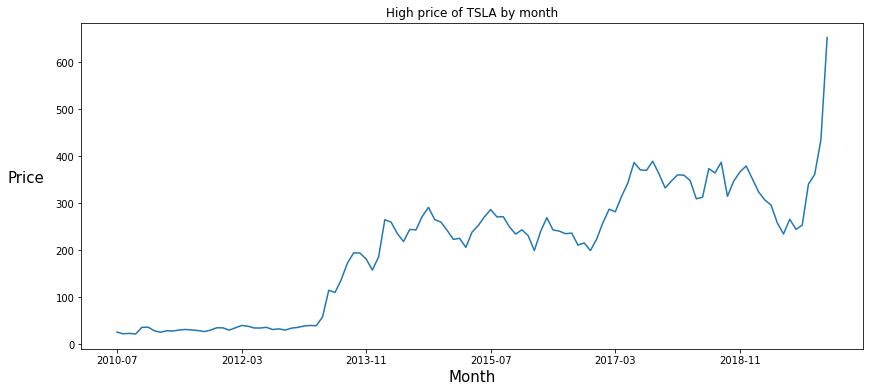

In [4]:
plt.figure(figsize = (14, 6))
plt.title('High price of TSLA by month')
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Price', rotation = 0, labelpad = 30, fontsize = 15)
df['High'].plot();

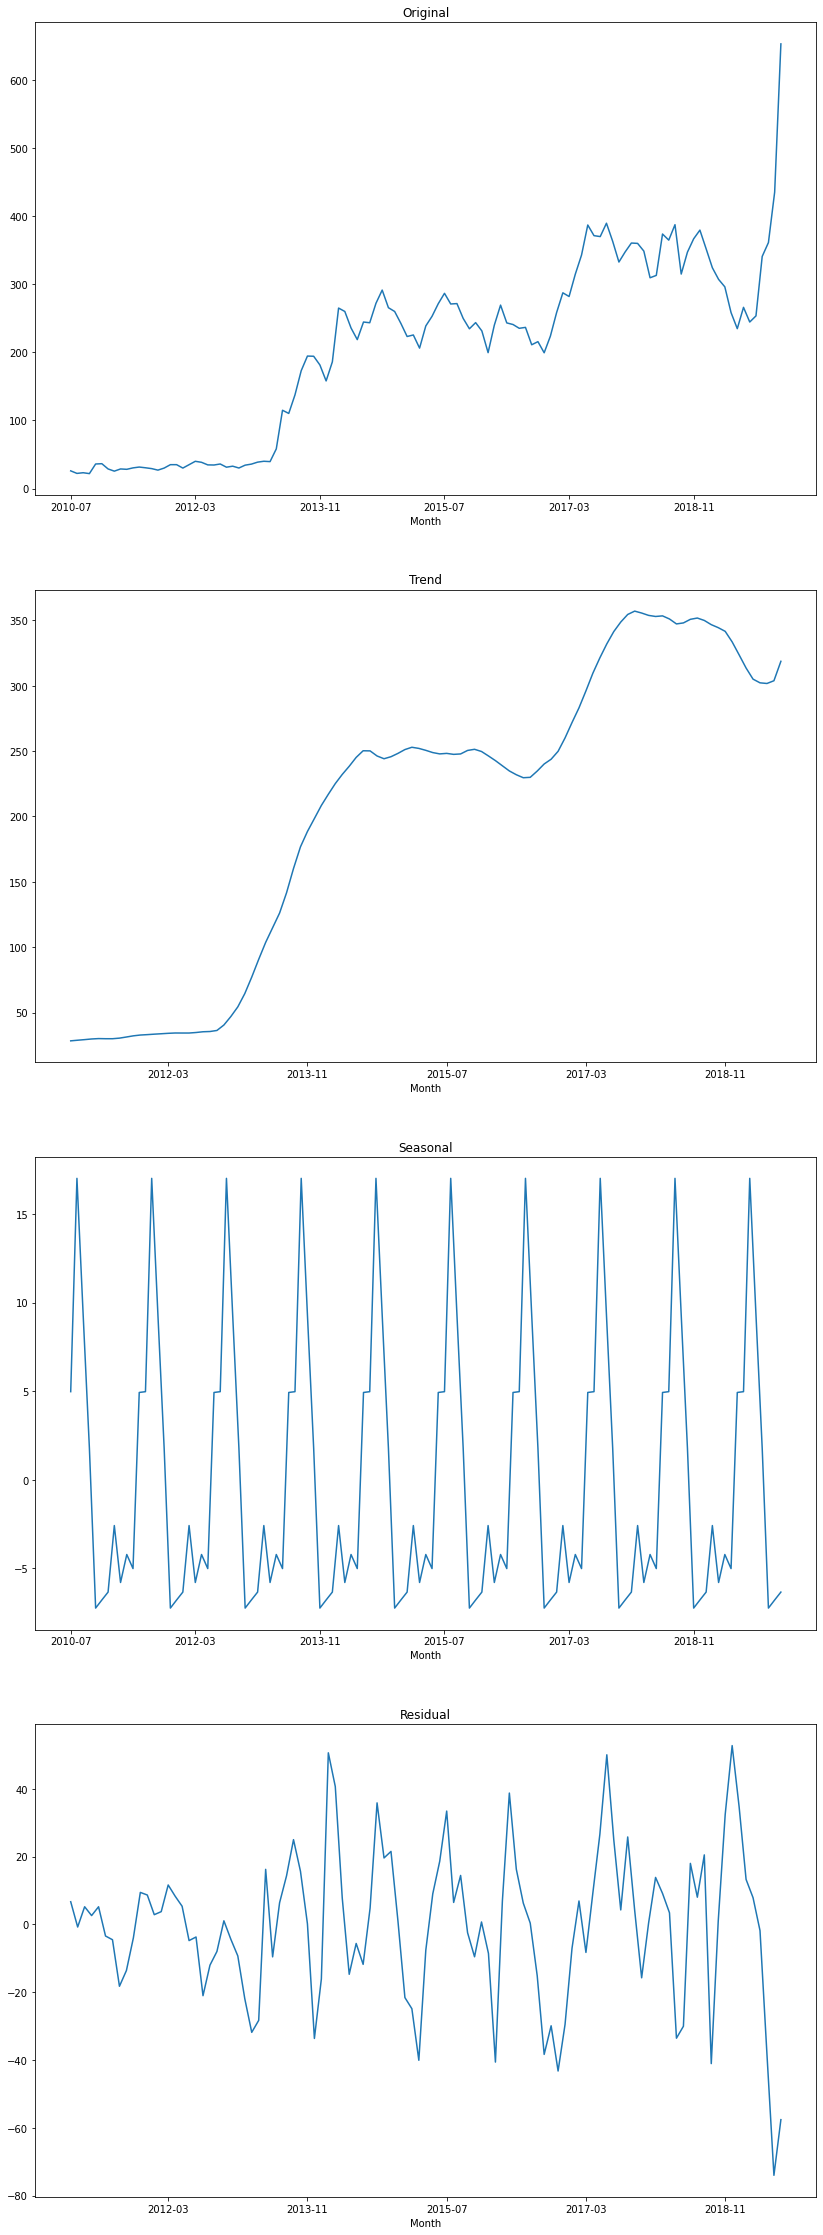

In [5]:
def plot_analysis(df, column):
    fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (14, 40))
    decompose = seasonal_decompose(df[[column]], period = 12)

    ax[0].set_title('Original')
    ax[1].set_title('Trend')
    ax[2].set_title('Seasonal')
    ax[3].set_title('Residual')

    decompose.observed.plot(ax = ax[0])
    decompose.trend.plot(ax = ax[1])
    decompose.seasonal.plot(ax = ax[2])
    decompose.resid.plot(ax = ax[3]);

plot_analysis(df, 'High')

Как видно из графиков, тренд присутствует, следовательно, нужно от него избавиться и привести ряд к стационарному виду.

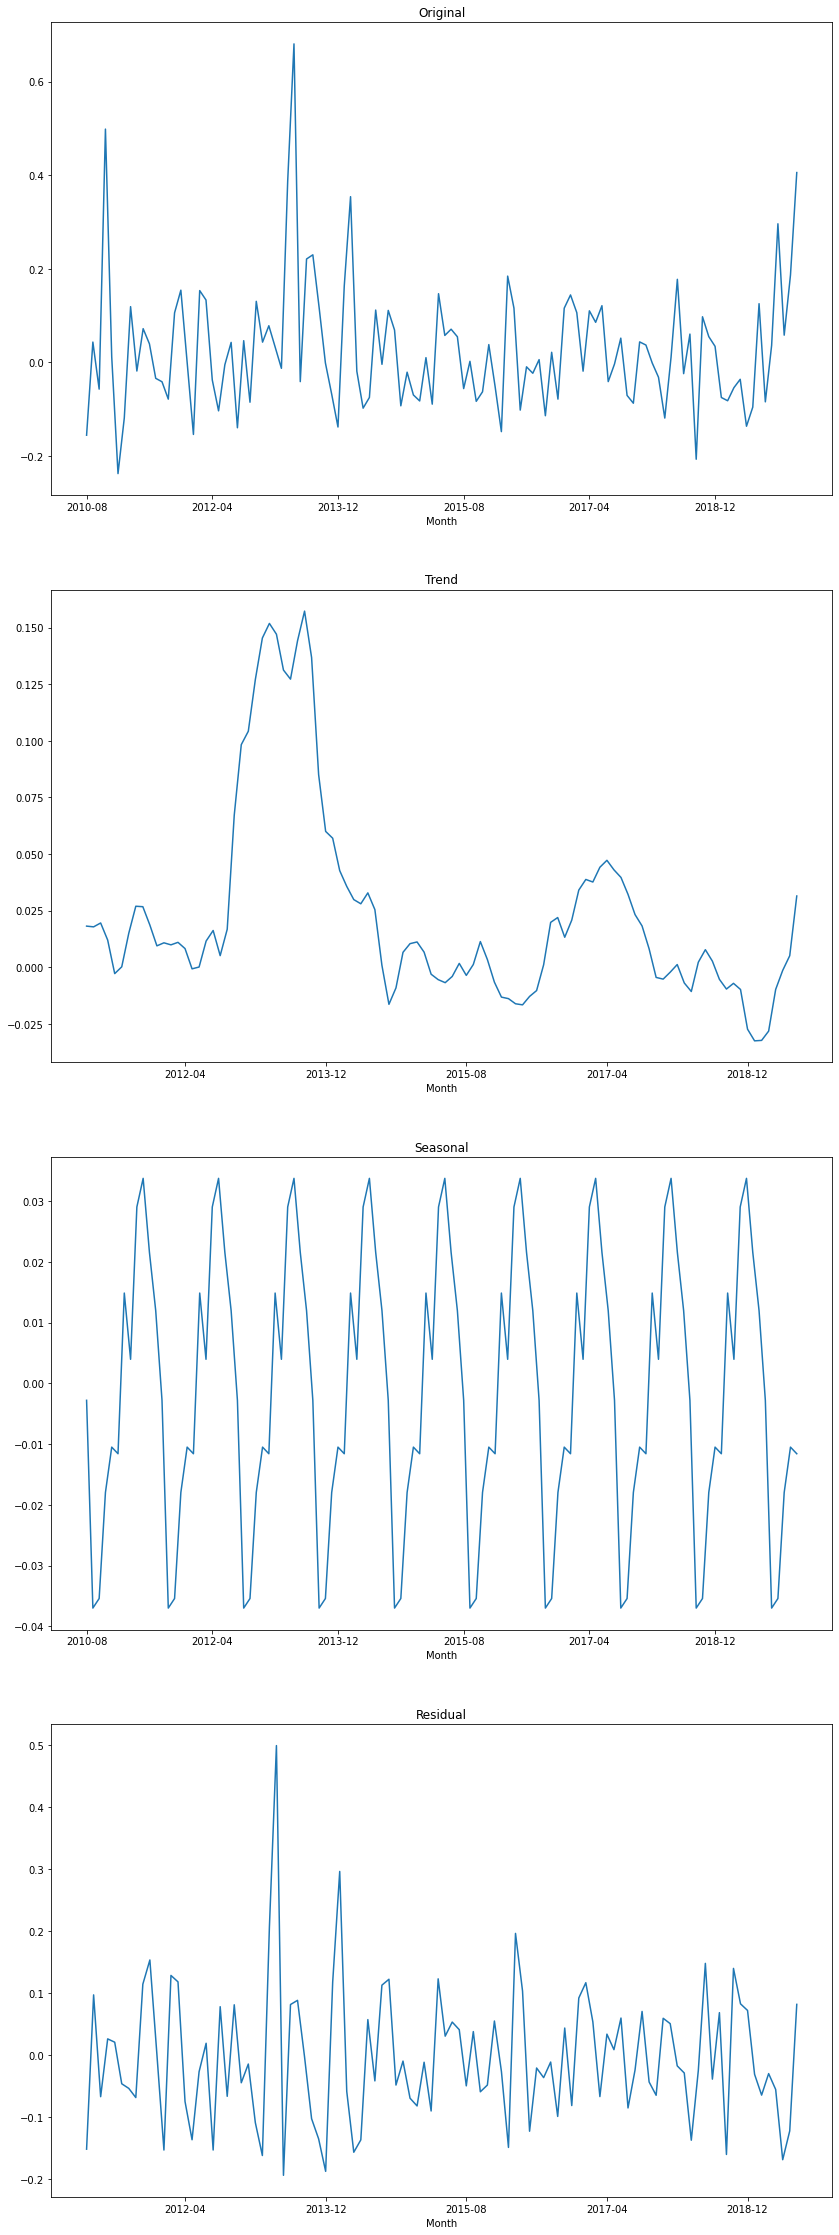

In [6]:
df['HighLog'] = np.log(df['High'])
df['HighLogDiff'] = df['HighLog'].diff()
plot_analysis(df[1:], 'HighLogDiff')

In [7]:
p_value = adfuller(df['HighLogDiff'][1:])[1]
print("P-Value: " + str(p_value))

P-Value: 5.566805017159901e-14


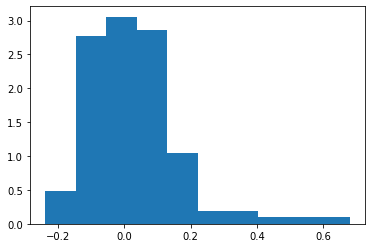

In [8]:
plt.hist(df['HighLogDiff'], density = True);

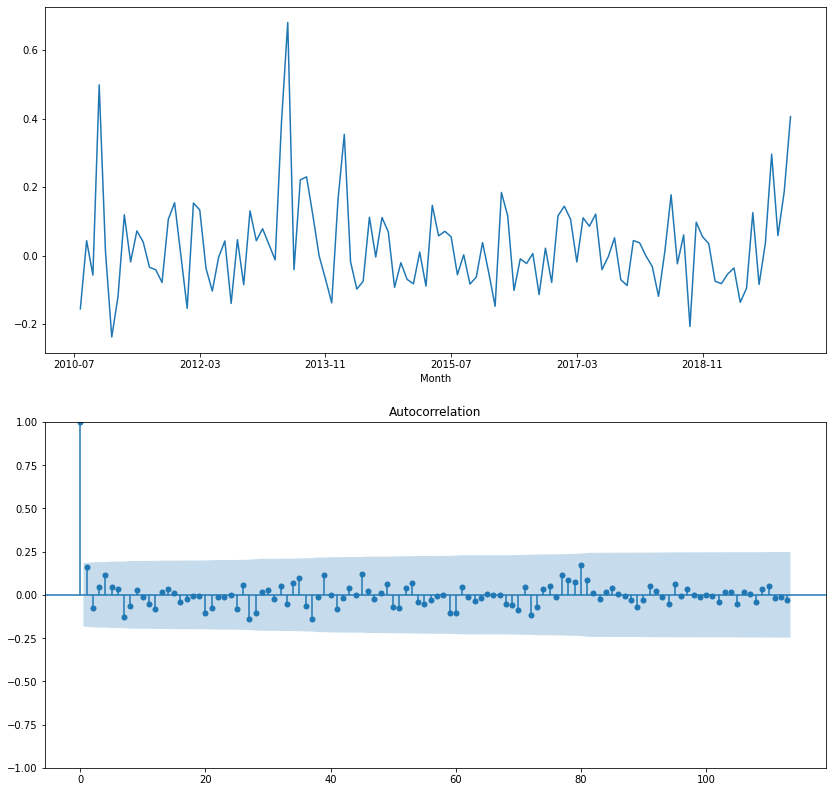

In [9]:
plt.figure(figsize = (14, 14))

ax = plt.subplot(211)
df['HighLogDiff'].plot(ax = ax)

ax = plt.subplot(212)
plot_acf(df['HighLogDiff'][1:], lags = df['HighLogDiff'].size - 2, ax = ax);

Проведя сначала логарифмическое, а затем дифференциальное преобразование, мы получили стационарный ряд.

## Обучение с учителем

In [10]:
qs = range(1, 5)
Qs = range(1, 3)
parameters = product(qs, qs, Qs, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

Обучим первые 80% выборки и попробуем на её основе предсказать оставшиеся 20%.

In [11]:
trainSize = round((df['HighLog'].size - 2) * 0.8)
trainSize

90

In [12]:
results = []
best_aic = float("inf")

warnings.filterwarnings('ignore')
for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            df['HighLog'][:trainSize], 
            order=(param[0], 1, param[1]), 
            seasonal_order=(param[2], 1, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [08:26<00:00,  7.92s/it]


In [13]:
predicted_values = best_model.predict(start = trainSize + 1, end = df['HighLog'].size).to_frame()
predicted_values.index = predicted_values.index.strftime('%Y-%m')
predicted_values.head()

,predicted_mean
2018-02,5.896952
2018-03,5.941111
2018-04,6.042514
2018-05,6.084647
2018-06,6.132215


In [14]:
df['HighLogPredicted'] = predicted_values
df['HighPredicted'] = np.exp(df['HighLogPredicted'])
df

,Open,High,Low,Close,HighLog,HighLogDiff,HighLogPredicted,HighPredicted
Month,,,,,,,,
2010-07,25.000000,25.920000,14.980000,19.940001,3.255015,NaN,NaN,NaN
2010-08,20.500000,22.180000,17.389999,19.480000,3.099191,-0.155824,NaN,NaN
2010-09,19.620001,23.160000,19.500000,20.410000,3.142427,0.043236,NaN,NaN
2010-10,20.690001,21.870001,20.000000,21.840000,3.085116,-0.057311,NaN,NaN
2010-11,21.940001,36.000000,21.049999,35.330002,3.583519,0.498403,NaN,NaN
...,...,...,...,...,...,...,...,...
2019-09,224.080002,253.500000,218.360001,240.869995,5.535364,0.036108,6.442798,628.162153
2019-10,241.500000,340.839996,224.279999,314.920013,5.831413,0.296049,6.400284,602.016216
2019-11,316.320007,361.200012,309.260010,329.940002,5.889432,0.058019,6.357278,576.674459


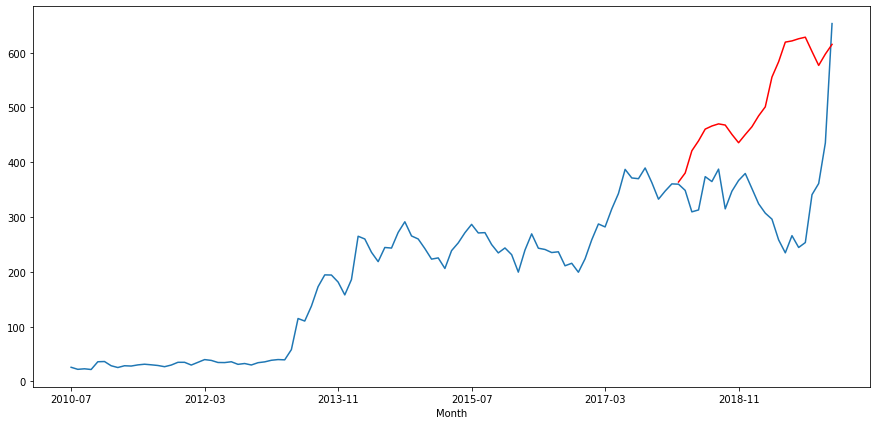

In [15]:
plt.figure(figsize = (15, 7))
df['High'].plot()
df['HighPredicted'].plot(c = 'r');

In [16]:
mape = mean_absolute_percentage_error(df['High'][trainSize + 1:], df['HighPredicted'][trainSize + 1:])
print("MAPE: " + str(mape))

MAPE: 0.588673503061992
